In [1]:
#################################### IMPORTING LIBRARIES ##############################################
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile
import tensorflow as tf
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.applications import VGG19, ResNet50

sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

## **Using flow_from_directory and fit_generator**

In [0]:
#################################### GETTING DATASET ##############################################
image_dir = '/flowerDataset/flower_photos'

# Read all images (.jpg) from a folder and adding path of an image and respective label in a list
def read_images_from_folder(base_dir, folder):
    path_folder = os.path.join(image_dir, folder)
    files_directory = os.listdir(path_folder)
    #declaring list to add image path and label
    labels = []
    images = []
    #looping through all images in folders of different categories of flowers
    for file in files_directory:
        if file.endswith('.jpg'):
            labels.append(folder)
            images.append(os.path.join(path_folder, file))
    return labels, images
#function to iterate through all folders
def read_allImages(base_dir):
    labels = []
    images = []
    folders = os.listdir(image_dir)
    for folder in folders:
        #adding images and coressponding labels
        labels_folder, images_folder = read_images_from_folder(base_dir, folder)
        labels.extend(labels_folder)
        images.extend(images_folder)
    return labels, images

labels, images = read_allImages(image_dir)
print(len(images), len(labels))


3670 3670


In [0]:
#splitting data into training and testing dataset
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=8, stratify=labels)
print('Done')
#checking the total number of images in training and validation dataset
print(len(images_train))
print(len(labels_train))
print(len(images_test))
print(len(labels_test))

Done
2569
2569
1101
1101


In [0]:
#checking data of image and labels list
print(labels_test[0])
print(images_test[0])
print(labels_train[0])
print(images_train[0])

roses
/content/drive/My Drive/flowerDataset/flower_photos/roses/6655078437_759fd626fd_n.jpg
dandelion
/content/drive/My Drive/flowerDataset/flower_photos/dandelion/2443192475_c64c66d9c2.jpg


In [0]:
#library for copying file 
import shutil
#defining training and testing data folder path
train_folder = '/flowerDataset/train'
test_folder = '/flowerDataset/test'

#creating training and testing folders
def create_folders():
  if not os.path.exists(train_folder):
    os.mkdir(train_folder)
    print(train_folder)
    #for each category create folder
    for label in set(labels):
      os.mkdir(train_folder + '/' + label)
  #creating test folder
  if not os.path.exists(test_folder):
    os.mkdir(test_folder)
    print(test_folder)
    for label in set(labels):
      os.mkdir(test_folder + '/' + label)
#copying files from original path to the new training and testing folders            
def copy_files_to_train_and_validation_folders():            
    print('Copy training files to directory')
    for index, value in enumerate(images_train):
      dest = os.path.join(train_folder, labels_train[index])
      #print(dest)
      shutil.copy(value, dest)
    #copying files to testing folders
    print('Copy test files to directory')        
    for index, value in enumerate(images_test):
      #print(value)
      shutil.copy(value, test_folder + '/' + labels_test[index])
#calling functions    
create_folders()
copy_files_to_train_and_validation_folders()
print('Done')

Copy training files to directory
Copy test files to directory
Done


In [2]:
#################################### DATA PROCESSING ##############################################
train_folder = '/flowerDataset/train'
test_folder = '/flowerDataset/test'
# Parameters
batch_size = 32
image_size=256
# Adding rescale to ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

#validation generator
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

# Using flow_from_directory
#setting class_mode to categorical asthere are 5 categories of flowers
#defining batch_size to generate number of images from the generator per batch 
train_generator = train_datagen.flow_from_directory(
   train_folder, target_size=(image_size, image_size), batch_size=batch_size, class_mode='categorical'
)
#Using flow_from_directory for getting validation dataset
val_generator = val_datagen.flow_from_directory(
   test_folder, target_size=(image_size, image_size), class_mode='categorical'
)

Found 2569 images belonging to 5 classes.
Found 1101 images belonging to 5 classes.


In [3]:
################################### BUILDING MODEL FROM SCRATCH #############################################
import tensorflow as tf

def create_model_from_scratch():
    #creating basic model using Sequential
    model = tf.keras.models.Sequential()
    #defining first layer
    model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', input_shape=(256,256,3), 
                                     activation='relu', name='conv_1'))
    #defining max pooling window of size 2,2
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool_1'))
    #defining second layer
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool_2'))
    #defining third layer
    model.add(Conv2D(100, (3,3), padding='same', activation='relu', name='conv_3'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool_3'))
    #defining fourth layer
    model.add(Conv2D(100, (3,3), activation='relu', name='conv_4'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool_4'))
    #adding Flatten layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512,  name='dense_1',activation='relu'))
    #adding finaloutput layer with activation softmax as it is multi classification
    model.add(tf.keras.layers.Dense(5, name='output',activation='softmax'))
    #compiling model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
    
    return model
#building model
model_scratch = create_model_from_scratch()
#printing model structure
model_scratch.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 128, 128, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 128, 128, 64)      18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 64, 64, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 64, 64, 100)       57700     
_________________________________________________________________
maxpool_3 (MaxPooling2D)     (None, 32, 32, 100)       0         
_________________________________________________________________
conv

In [5]:
#training model using fit_generator
model_scratch_history=model_scratch.fit_generator(train_generator, steps_per_epoch=50, 
                            validation_data=val_generator, validation_steps=1, 
                            verbose=2,epochs=20)

Epoch 1/20
35/35 [==============================] - 6s 170ms/step - loss: 2.4356 - acc: 0.6340
 - 19s - loss: 0.0344 - acc: 0.9910 - val_loss: 2.4356 - val_acc: 0.6340
Epoch 2/20
35/35 [==============================] - 6s 171ms/step - loss: 2.3893 - acc: 0.6331
 - 17s - loss: 0.1028 - acc: 0.9739 - val_loss: 2.3893 - val_acc: 0.6331
Epoch 3/20
35/35 [==============================] - 6s 165ms/step - loss: 2.7091 - acc: 0.6085
 - 18s - loss: 0.0363 - acc: 0.9879 - val_loss: 2.7091 - val_acc: 0.6085
Epoch 4/20
35/35 [==============================] - 6s 168ms/step - loss: 2.6631 - acc: 0.6085
 - 17s - loss: 0.0314 - acc: 0.9934 - val_loss: 2.6631 - val_acc: 0.6085
Epoch 5/20
35/35 [==============================] - 6s 174ms/step - loss: 2.7716 - acc: 0.6431
 - 19s - loss: 0.0176 - acc: 0.9946 - val_loss: 2.7716 - val_acc: 0.6431
Epoch 6/20
35/35 [==============================] - 6s 173ms/step - loss: 2.7877 - acc: 0.6494
 - 18s - loss: 0.0032 - acc: 0.9992 - val_loss: 2.7877 - val_acc:

## **Transfer Learning**

In [22]:
######################################### BUILDING MODEL FROM VGG19 #############################################
def create_model_from_VGG19():
    #load VGG19 model with pretrained weights
    #include_top: whether to add 3 fully connected layers on top or not
    model = VGG19(weights = "imagenet", include_top=False, input_shape = (256,256,3))
    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    #adding dense layer with filter size 256
    x = Dense(256, activation="relu")(x)
    #using dropout layer
    x = Dropout(0.25)(x)
    #final output layer with softmax activation
    predictions = Dense(5, activation="softmax")(x)
    # creating the final model 
    final_model = Model(inputs = model.input, outputs = predictions)
    #freezing top 15 layers of the model
    for layer in model.layers[:25]:
      layer.trainable = False
    #using RMSprop optimizer with learning rate 
    opt = RMSprop(lr=0.0003)
    #compiling the model
    final_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 
    return final_model

#building the model
model_VGG19 = create_model_from_VGG19()
#printing model structure
model_VGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [23]:
############################### TRAINING MODEL ######################################################
#steps_per_epoch: used in generating the entire dataset by calling the generator steps_per_epoch times
#validation_steps: used by validation generator to get validation_steps batches
model_VGG19_history=model_VGG19.fit_generator(train_generator, steps_per_epoch=50, 
                            validation_data=val_generator, validation_steps=1, 
                            verbose=2,epochs=20)

Epoch 1/20
35/35 [==============================] - 8s 241ms/step - loss: 0.8507 - acc: 0.6885
 - 27s - loss: 2.0797 - acc: 0.5193 - val_loss: 0.8507 - val_acc: 0.6885
Epoch 2/20
35/35 [==============================] - 9s 247ms/step - loss: 0.8066 - acc: 0.7166
 - 27s - loss: 0.8113 - acc: 0.7143 - val_loss: 0.8066 - val_acc: 0.7166
Epoch 3/20
35/35 [==============================] - 9s 249ms/step - loss: 0.6443 - acc: 0.7629
 - 28s - loss: 0.6240 - acc: 0.7715 - val_loss: 0.6443 - val_acc: 0.7629
Epoch 4/20
35/35 [==============================] - 9s 254ms/step - loss: 0.7631 - acc: 0.7239
 - 29s - loss: 0.4803 - acc: 0.8315 - val_loss: 0.7631 - val_acc: 0.7239
Epoch 5/20
35/35 [==============================] - 9s 244ms/step - loss: 0.6887 - acc: 0.7620
 - 28s - loss: 0.4082 - acc: 0.8571 - val_loss: 0.6887 - val_acc: 0.7620
Epoch 6/20
35/35 [==============================] - 9s 247ms/step - loss: 0.6698 - acc: 0.7766
 - 28s - loss: 0.3118 - acc: 0.8945 - val_loss: 0.6698 - val_acc:

In [8]:
#loading pretrained weights of the resnet50
WEIGHTS_PATH_NO_TOP = '/flowerDataset/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
#building transfer model
def create_model_from_ResNet50():
    #using simple model Sequential
    model = Sequential()
    #adding trained model resnet50 with pretrained weights
    model.add(ResNet50(include_top=False, pooling='avg', weights=WEIGHTS_PATH_NO_TOP))
    model.add(Flatten())
    #using batchNormalization
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    #final output layer with softmax activation as  5 classes of flowers
    model.add(Dense(5, activation='softmax'))
    #freezing layer
    model.layers[0].trainable = False
    #compiling the model using adam as optimizer 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
    
    return model
  
#building model
model_ResNet50 = create_model_from_ResNet50()
#printing transferred resNet50 model structure
model_ResNet50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 1024)              4096      
__________

In [9]:
#################################### TRAINING MODEL ######################################################
#using fit_generator
model_ResNet50_history=model_ResNet50.fit_generator(train_generator, steps_per_epoch=50, 
                            validation_data=val_generator, validation_steps=1, 
                            verbose=2,epochs=20)

Epoch 1/20
35/35 [==============================] - 9s 251ms/step - loss: 4.5779 - acc: 0.1726
 - 26s - loss: 1.0713 - acc: 0.7867 - val_loss: 4.5779 - val_acc: 0.1726
Epoch 2/20
35/35 [==============================] - 8s 217ms/step - loss: 6.0239 - acc: 0.2443
 - 22s - loss: 0.2035 - acc: 0.9354 - val_loss: 6.0239 - val_acc: 0.2443
Epoch 3/20
35/35 [==============================] - 8s 230ms/step - loss: 3.4717 - acc: 0.1698
 - 22s - loss: 0.1362 - acc: 0.9548 - val_loss: 3.4717 - val_acc: 0.1698
Epoch 4/20
35/35 [==============================] - 8s 223ms/step - loss: 6.6786 - acc: 0.2461
 - 22s - loss: 0.1174 - acc: 0.9580 - val_loss: 6.6786 - val_acc: 0.2461
Epoch 5/20
35/35 [==============================] - 8s 217ms/step - loss: 2.5076 - acc: 0.4051
 - 23s - loss: 0.0606 - acc: 0.9770 - val_loss: 2.5076 - val_acc: 0.4051
Epoch 6/20
35/35 [==============================] - 8s 218ms/step - loss: 3.0040 - acc: 0.4260
 - 22s - loss: 0.0651 - acc: 0.9794 - val_loss: 3.0040 - val_acc:

model_scratch


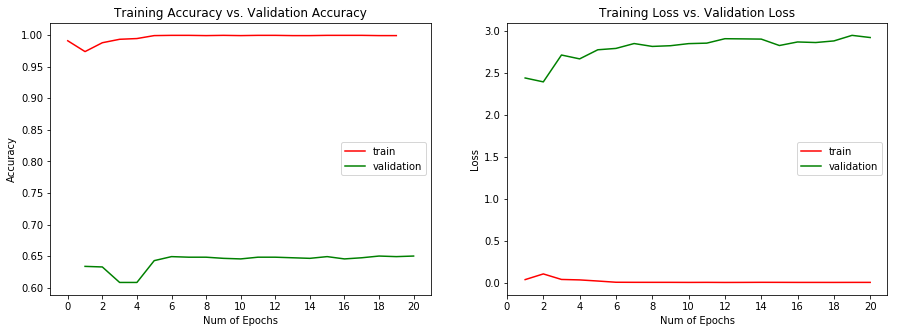

model_VGG19


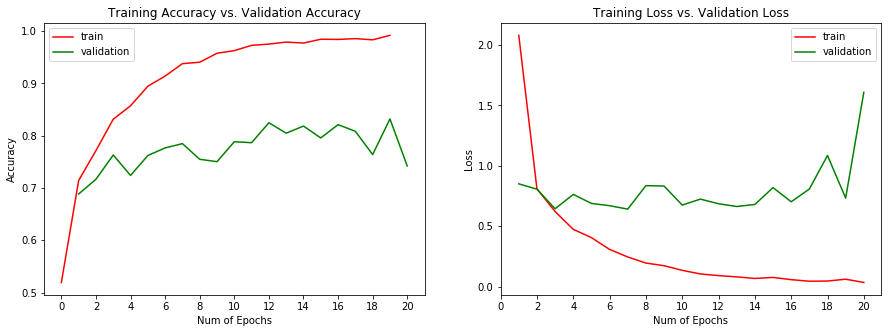

model_ResNet50


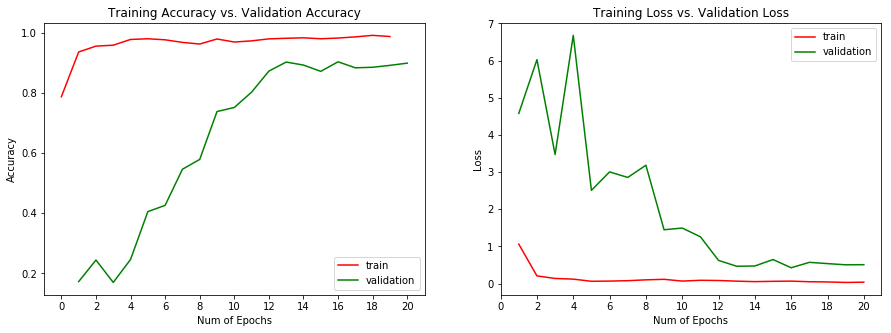

In [24]:
#################################### PLOTTING LOSS, ACCURACY ###########################################
# function to plot training and testing process: loss and accuracy
def plot_model_history(model_name, history, epochs):
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.show()
#calling function for all three models
plot_model_history('model_scratch', model_scratch_history.history, 20)
plot_model_history('model_VGG19', model_VGG19_history.history, 20)
plot_model_history('model_ResNet50', model_ResNet50_history.history, 20)

## **Predicting Image**

Using model from scratch
dandelion 93%


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


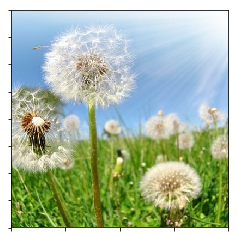

Using model from VGG19
dandelion 100%


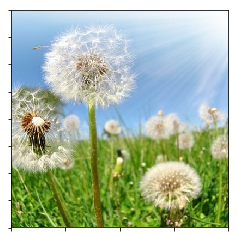

Using model from ResNet50
dandelion 100%


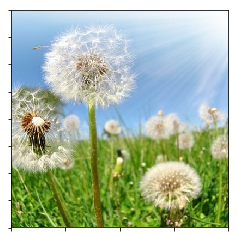

In [14]:
#function to convert image to RGB
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
#function to predict one image
def predict_one_image(img, model):
  #INTER_CUBIC:used to enlarge the image
  img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_CUBIC)
  #reshaping and scaling the image
  img = np.reshape(img, (1, 256, 256, 3))
  img = img/255.
  #predicting the image and get the category(class)
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

#get all the categories
label_map = (train_generator.class_indices)


print('Using model from scratch')
#path of an image to be tested
test_img = cv2.imread('/flowerDataset/toTestImages/dandelion1.jpg')
#predicting and find the probability
pred, probability = predict_one_image(test_img, model_scratch)
print('%s %d%%' % (list(label_map.keys())[list(label_map.values()).index(pred)], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# for not showing tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

print('Using model from VGG19')
#test_img = cv2.imread('/content/drive/My Drive/flowerDataset/flower_photos/rose2.jpg')
pred, probability = predict_one_image(test_img, model_VGG19)
print('%s %d%%' % (list(label_map.keys())[list(label_map.values()).index(pred)], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

print('Using model from ResNet50')
#test_img = cv2.imread('/content/drive/My Drive/flowerDataset/flower_photos/rose2.jpg')
pred, probability = predict_one_image(test_img, model_ResNet50)
print('%s %d%%' % (list(label_map.keys())[list(label_map.values()).index(pred)], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

## **Visualizing heatmaps**

In [25]:
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

# path of an image to be predicted
img_path = '/flowerDataset/toTestImages/rose2.jpg'

#resizing image of size 256x256
img = image.load_img(img_path, target_size=(256, 256))
#converting to an array
x = image.img_to_array(img)
#reshaping and rescaling image
#x = np.reshape(x, (1, 256, 256, 3))
x = np.expand_dims(x, axis=0)
x = x/255.
#predicting image using transferred VGG19 model
preds = model_VGG19.predict(x)
#get the category ofpredicted image
class_num = np.argmax(preds)
print(class_num)
print(preds)
#get the max probability of the classto which an image is predicted
max_ind=np.argmax(preds[0])
print(max_ind)

2
[[1.9741300e-07 3.2441715e-08 9.9999940e-01 7.9673629e-10 2.9946636e-07]]
2


In [26]:
########################### printing all layers of the model
[layer.name for layer in model_VGG19.layers]

['input_3',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool',
 'flatten_3',
 'dense_5',
 'dropout_1',
 'dense_6']

In [0]:
#using backend keras module for heatmaps calculation
from tensorflow.python.keras import backend as K
#specify the layers names to be used for heatmaps
layer_names = ['block1_conv1', 'block1_conv2', 
               'block2_conv1', 'block2_conv2', 
               'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4',
               'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4',
               'block5_conv1', 'block5_conv2', 'block5_conv3','block5_conv4']

# gets prediction vector
pred_vector_output = model_VGG19.output[:, max_ind]
heatmap = []
for layer_name in layer_names:
    #the output feature map of the model
    some_conv_layer = model_VGG19.get_layer(layer_name)

    # getting gradient of the predicted class with regard to
    # the output feature map of selected block
    grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]

    #mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    #to access the values of 'pooled_grads' and the output feature map of the layer,
    iterate = K.function([model_VGG19.input], [pooled_grads, some_conv_layer.output[0]])

    #in numpy array format
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # Multipling each channel in the feature map array with regard to the rose class
    for i in range(model_VGG19.get_layer(layer_name).output_shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # calculating mean channel-wise of the resulting feature map
    # and appending to heatmap
    heatmap.append(np.mean(conv_layer_output_value, axis=-1))

In [28]:
#checking the length of the heatmap
len(heatmap)

16

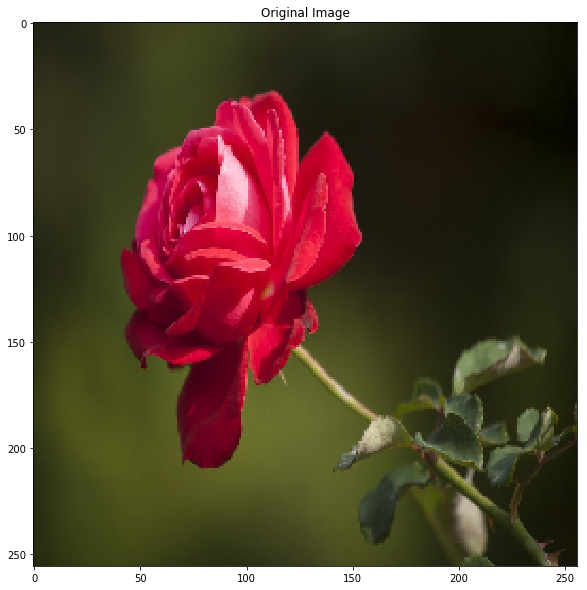

In [29]:
#plotting original image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title('Original Image')
plt.show()

0


<Figure size 1296x1296 with 0 Axes>

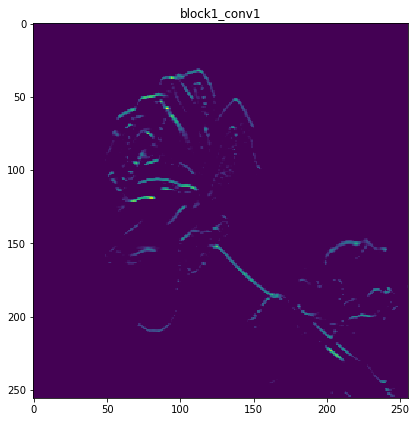

1


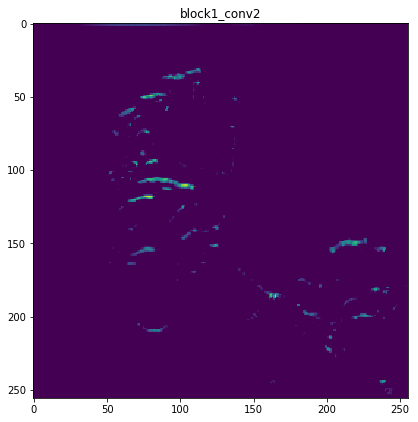

2


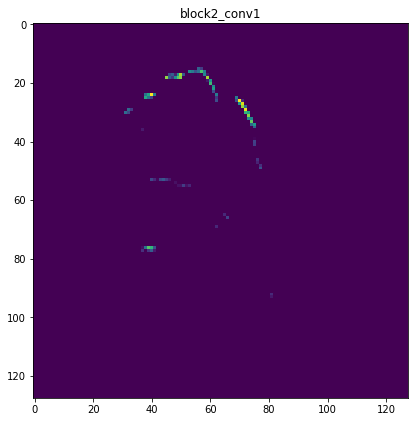

3


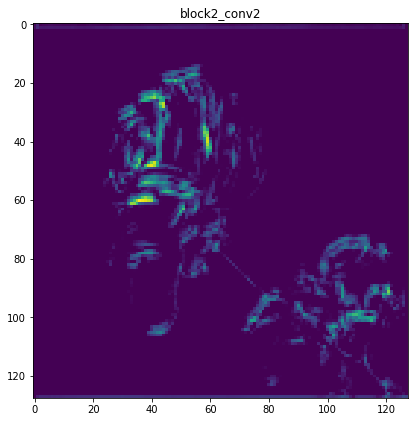

4


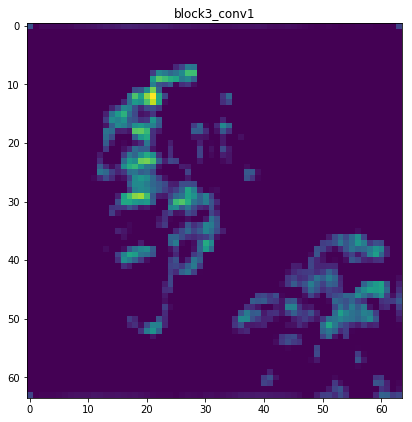

5


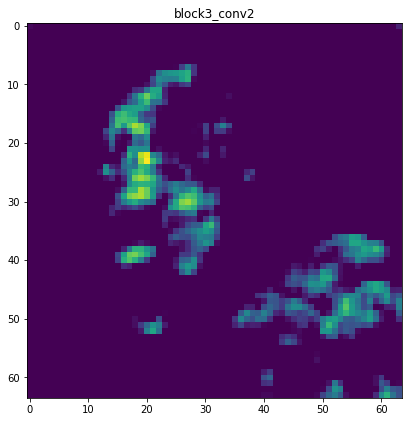

6


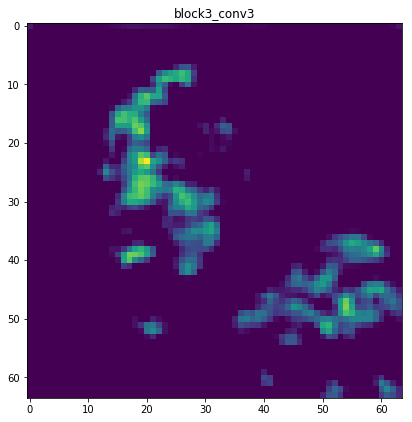

7


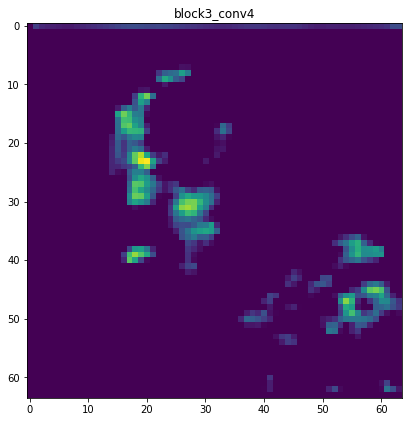

8


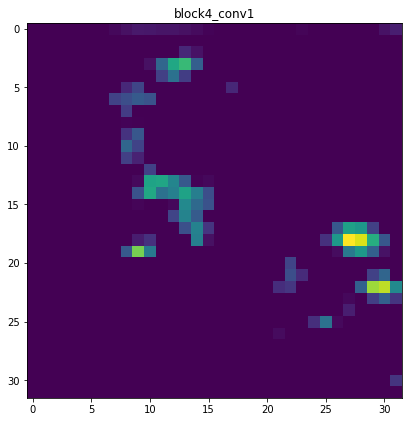

9


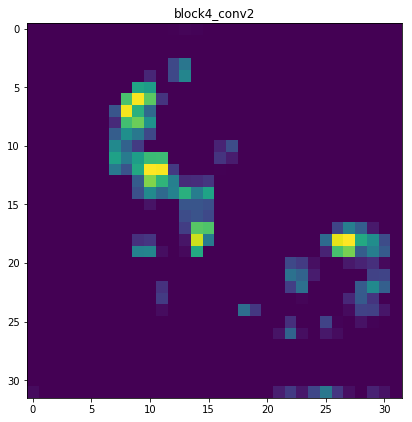

10


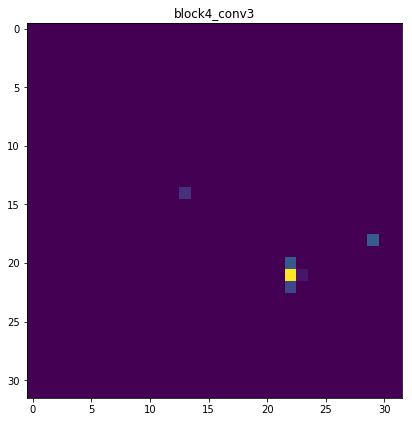

11


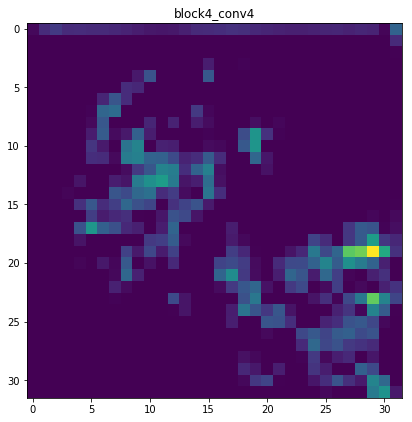

12


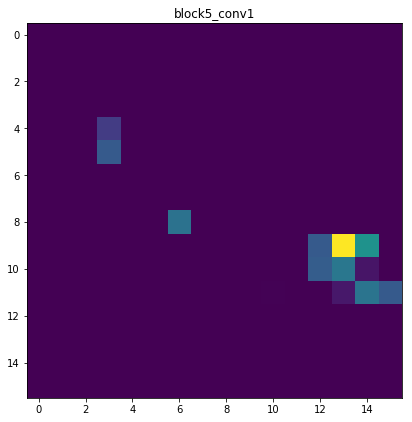

13


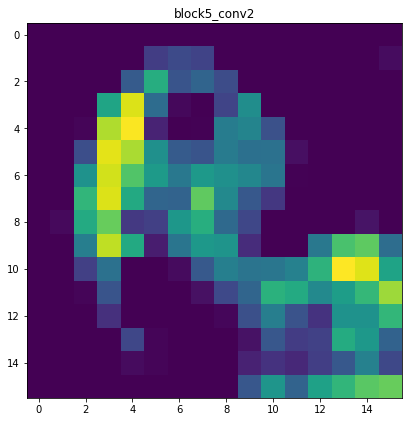

14


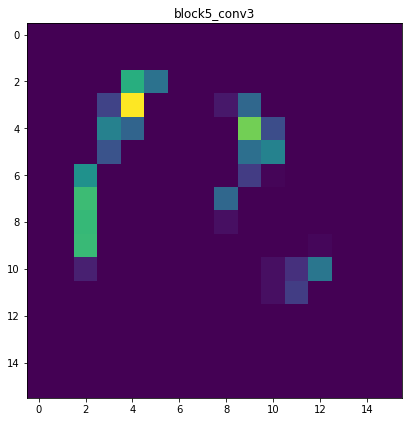

15


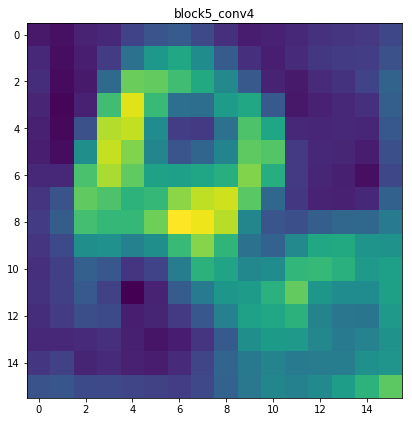

In [30]:
#plotting all the heatmap for all the blocks
plt.figure(figsize=(18, 18))

for i in range(16):
    plt.figure(figsize=(40,40))
    print(i)
    plt.subplot(5, 4, i+1)
    img_heatmap = np.maximum(heatmap[i], 0)
    img_heatmap /= np.max(img_heatmap)
    plt.imshow(img_heatmap)
    plt.title(layer_names[i])
    plt.show()

In [0]:
import cv2
#read the original image
img = cv2.imread(img_path)
for i, hm in enumerate(heatmap):
    #access heatmap
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    #resizing the heatmap to the same size as the original image
    img_hm = cv2.resize(img_heatmap, (img.shape[1], img.shape[0]))
    # converting heatmap to RGB
    img_hm = np.uint8(255 * img_hm)
    #applying heatmap to the original image in COLORMAP_JET format
    img_hm = cv2.applyColorMap(img_hm, cv2.COLORMAP_JET)
    # 0.4:heatmap intensity factor and superimposed heatmap on original image
    superimposed_img = img_hm * 0.4 + img
    # Save the image to disk
    cv2.imwrite('/flowerDataset/toTestImages/heatmapOutput/rose2_{}.jpg'.format(layer_names[i]), superimposed_img)

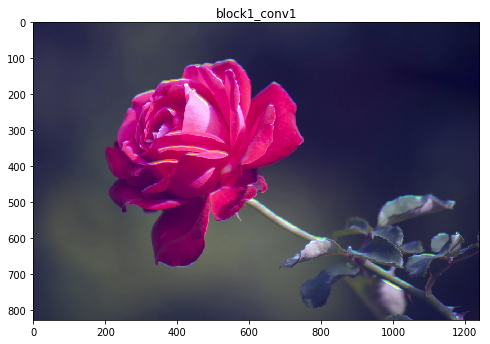

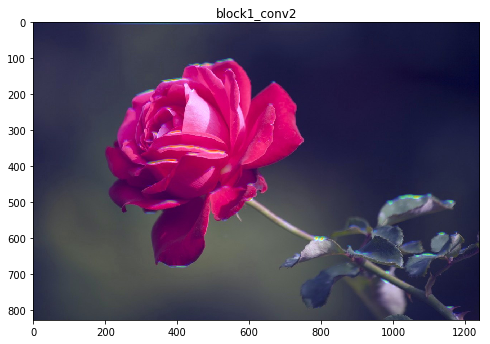

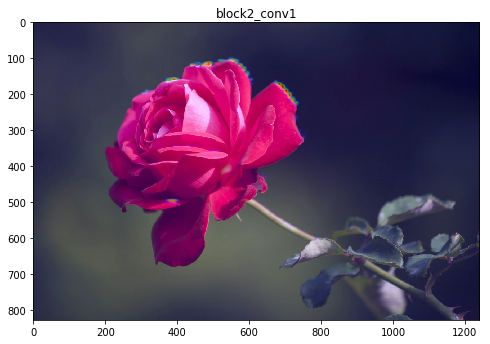

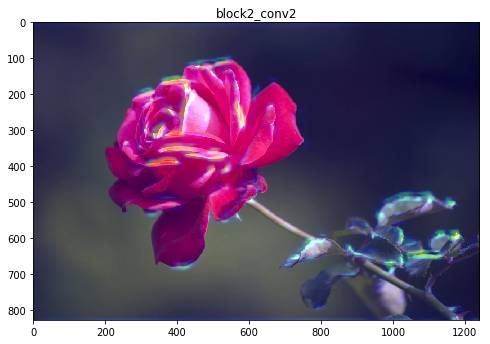

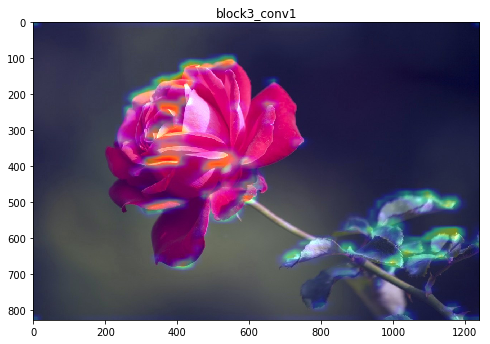

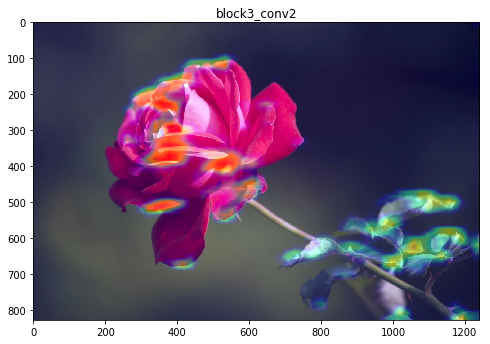

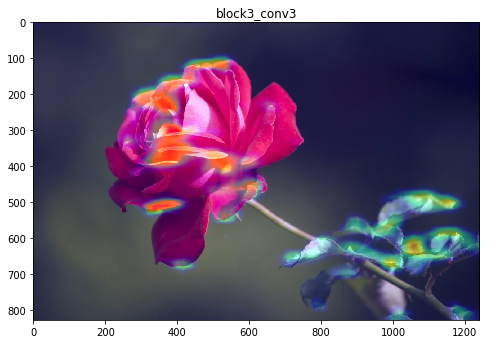

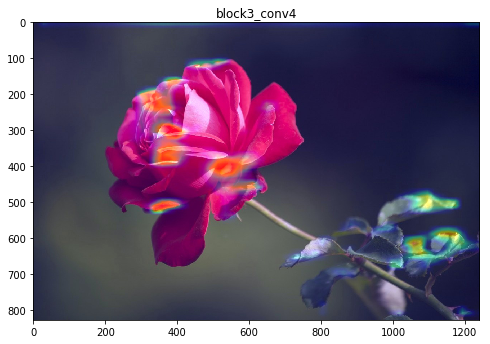

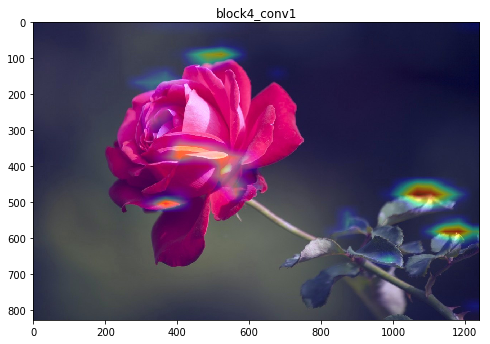

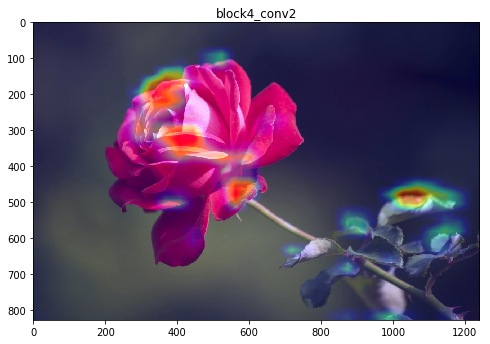

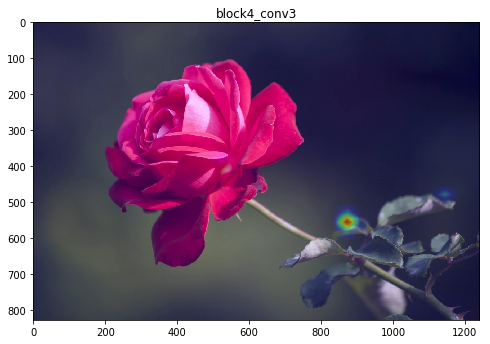

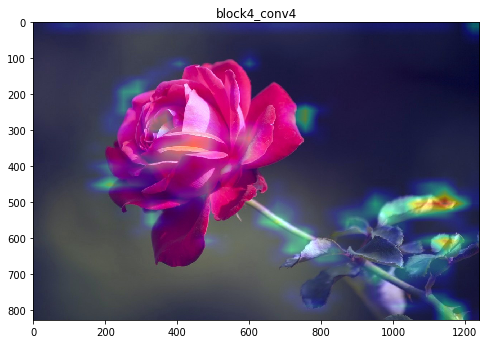

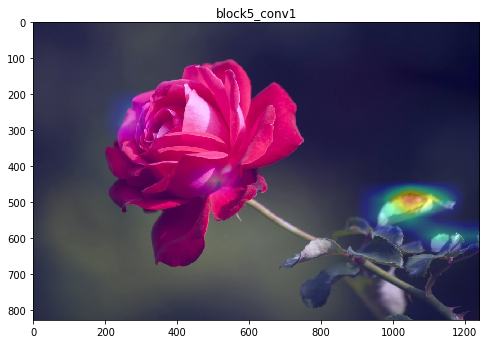

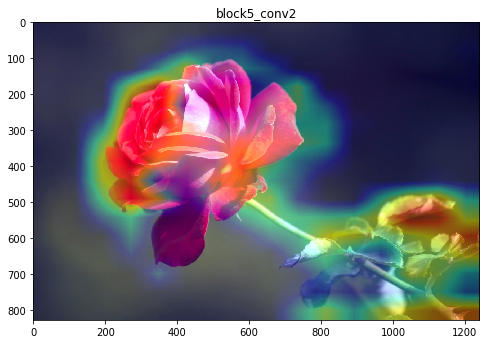

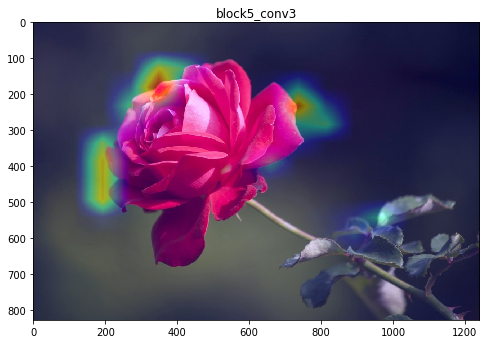

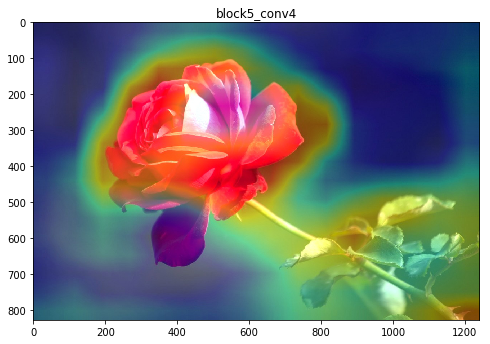

In [32]:
#plotting all heatmap images
for i in range(len(layer_names)):
  img_to_plot = image.img_to_array(
      image.load_img('/flowerDataset/toTestImages/heatmapOutput/rose2_{}.jpg'.format(layer_names[i]))) / 255.
  fig = plt.figure(figsize=(8, 8))
  plt.imshow(img_to_plot)
  plt.title(layer_names[i])
  

## **Heatmaps Visualization Using Model From Scratch**

In [33]:
from tensorflow.python.keras.preprocessing import image
#from tensorflow.python.keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

# path of an image to be predicted
img_path = '/flowerDataset/toTestImages/rose2.jpg'

#resizing image of size 256x256
img = image.load_img(img_path, target_size=(256, 256))
#converting to an array
x = image.img_to_array(img)
#reshaping and rescaling image
#x = np.reshape(x, (1, 256, 256, 3))
x = np.expand_dims(x, axis=0)
x = x/255.
#predicting image using transferred VGG19 model
preds = model_scratch.predict(x)
#get the category ofpredicted image
class_num = np.argmax(preds)
print(class_num)
print(preds)
#get the max probability of the classto which an image is predicted
max_ind=np.argmax(preds[0])
print(max_ind)

2
[[9.2651609e-11 2.4358701e-16 1.0000000e+00 3.0964481e-13 1.5299819e-09]]
2


In [34]:
########################### printing all layers of the model
[layer.name for layer in model_scratch.layers]

['conv_1',
 'maxpool_1',
 'conv_2',
 'maxpool_2',
 'conv_3',
 'maxpool_3',
 'conv_4',
 'maxpool_4',
 'flatten',
 'dense_1',
 'output']

In [36]:
#using backend keras module for heatmaps calculation
from tensorflow.python.keras import backend as K
#specify the layers names to be used for heatmaps
layer_names = ['conv_1', 'conv_2', 
               'conv_3', 'conv_4',
               ]

# gets prediction vector
pred_vector_output = model_scratch.output[:, max_ind]
heatmap = []
for layer_name in layer_names:
    #the output feature map of the model
    some_conv_layer = model_scratch.get_layer(layer_name)

    # getting gradient of the predicted class with regard to
    # the output feature map of selected block
    grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]

    #mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    #to access the values of 'pooled_grads' and the output feature map of the layer,
    iterate = K.function([model_scratch.input], [pooled_grads, some_conv_layer.output[0]])

    #in numpy array format
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # Multipling each channel in the feature map array with regard to the rose class
    for i in range(model_scratch.get_layer(layer_name).output_shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # calculating mean channel-wise of the resulting feature map
    # and appending to heatmap
    heatmap.append(np.mean(conv_layer_output_value, axis=-1))

#checking the length of the heatmap
len(heatmap)

4

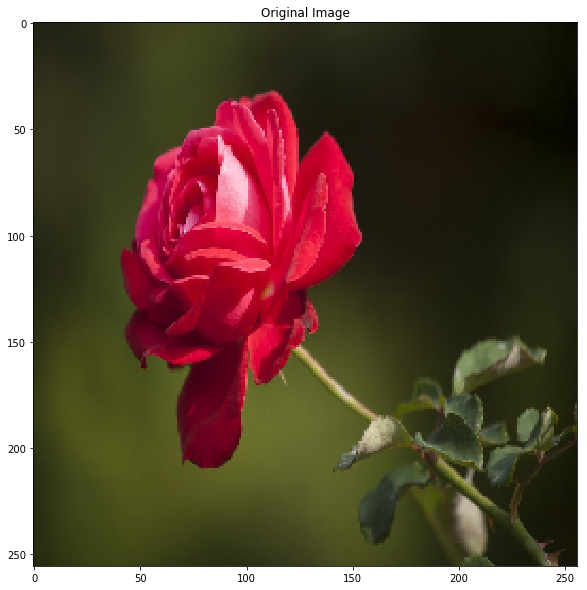

In [37]:
#plotting original image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title('Original Image')
plt.show()

<Figure size 1296x1296 with 0 Axes>

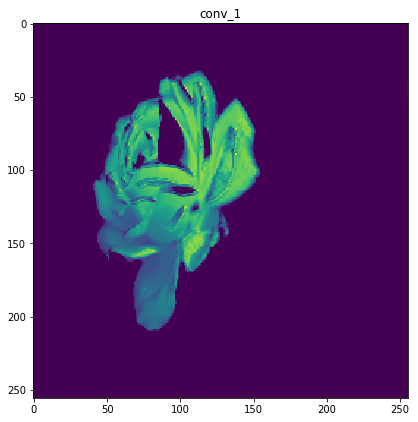

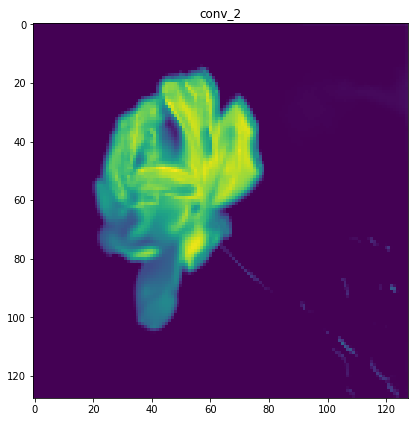

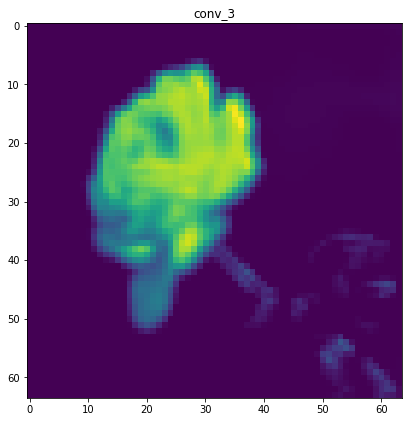

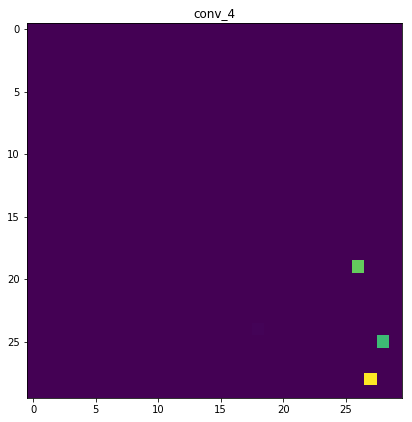

In [40]:
#plotting all the heatmap for all the blocks
plt.figure(figsize=(18, 18))

for i in range(4):
    plt.figure(figsize=(40,40))
    #print(i)
    plt.subplot(5, 4, i+1)
    img_heatmap = np.maximum(heatmap[i], 0)
    img_heatmap /= np.max(img_heatmap)
    plt.imshow(img_heatmap)
    plt.title(layer_names[i])
    plt.show()

In [0]:
import cv2
#read the original image
img = cv2.imread(img_path)
for i, hm in enumerate(heatmap):
    #access heatmap
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    #resizing the heatmap to the same size as the original image
    img_hm = cv2.resize(img_heatmap, (img.shape[1], img.shape[0]))
    # converting heatmap to RGB
    img_hm = np.uint8(255 * img_hm)
    #applying heatmap to the original image in COLORMAP_JET format
    img_hm = cv2.applyColorMap(img_hm, cv2.COLORMAP_JET)
    # 0.4:heatmap intensity factor and superimposed heatmap on original image
    superimposed_img = img_hm * 0.4 + img
    # Save the image to disk
    cv2.imwrite('/flowerDataset/toTestImages/heatmapOutput1/rose2_{}.jpg'.format(layer_names[i]), superimposed_img)

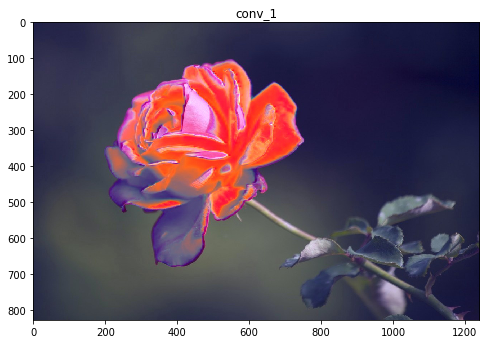

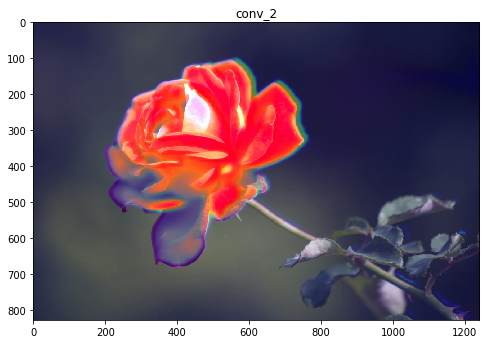

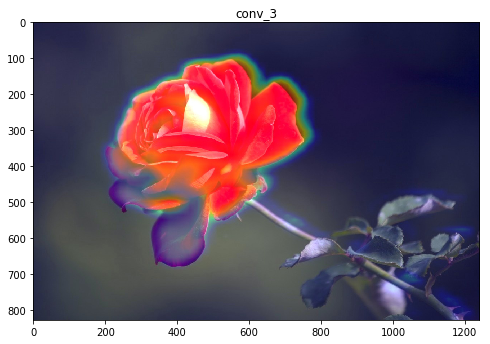

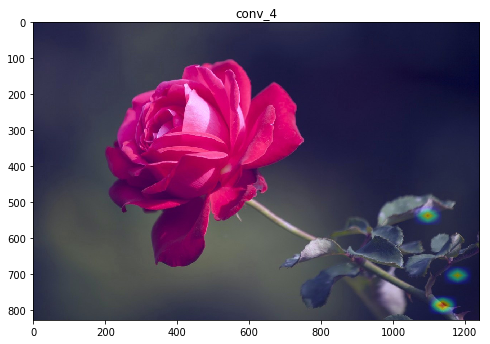

In [42]:
#plotting all heatmap imagess
for i in range(len(layer_names)):
  img_to_plot = image.img_to_array(
      image.load_img('/flowerDataset/toTestImages/heatmapOutput1/rose2_{}.jpg'.format(layer_names[i]))) / 255.
  fig = plt.figure(figsize=(8, 8))
  plt.imshow(img_to_plot)
  plt.title(layer_names[i])
  